In [12]:
import numpy as np
import seaborn as sns
import scipy.stats as stats

Objetivo:replicar o cálculo do I de Moran feito pela biblioteca esda.moran.
nesse exemplo a matriz de pesos foi calculada manualmente para melhor entendimento.

Fonte:
- https://geokrigagem.com.br/como-calcular-o-indice-moran-autocorrelacao-espacial/
- figura retirada de [CÂMARA, G. et al. ANÁLISE ESPACIAL DE ÁREAS. p. 44, [s.d.].](http://www.dpi.inpe.br/gilberto/livro/analise/cap5-areas.pdf)


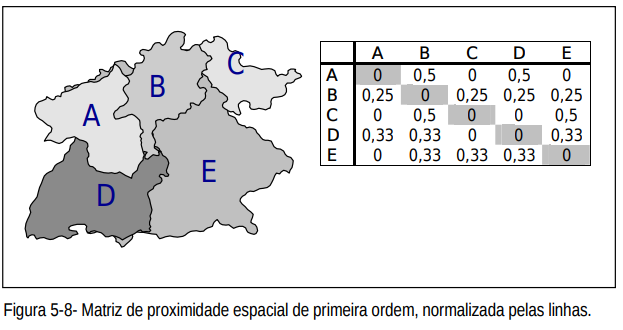

Valores das regiões e matriz de vizinhança com pesos

In [75]:
#x = np.array([2,3,8,3,1])
x = np.array([1,12,25,17,10,4,2])
z = x - x.mean()
w_ = np.array([
    [0, 0.5, 0, 0.5, 0],
    [0.25, 0, 0.25, 0.25, 0.25],
    [0, 0.5, 0, 0, 0.5],
    [0.33,0.33,0,0,0.33],
    [0, 0.33, 0.33, 0.33, 0]
])
w = np.array([
    [0,1,1,0,0,0,0],
    [1,0,1,1,0,1,1],
    [1,1,0,1,1,0,0],
    [0,1,1,0,1,1,0],
    [0,0,1,1,0,1,0],
    [0,1,0,1,1,0,1],
    [0,1,0,0,0,1,0]
])
n = x.size

Algumas variáveis calculadas da matriz de pesos

In [76]:
s0 = w.sum().sum()
s1 = np.array([(w[i,j] + w[j,i]) ** 2 for i in range(n) for j in range(n)]).sum() * 0.5
s2 = np.array([(w[i,:].sum() + w[:,i].sum()) ** 2 for i in range(n)]).sum()

Calcular o I

In [77]:
def moran(z, w):
    I_numerador = np.array([w[i,j] * z[i] * z[j] for i in range(z.size) for j in range(z.size)]).sum() * z.size
    I_denominador = w.sum().sum() * (z ** 2).sum()
    return I_numerador / I_denominador

Calcular E[I] e E[I²] = (A - B) / C 

In [78]:
EI = -(1 / (n - 1))

z4 = z ** 4
z2 = z ** 2
k = (z4.sum() / n) / ((z2.sum() / n) ** 2)

A = n * ((n ** 2 - 3 * n + 3) * s1 - n * s2 + 3 * s0 ** 2)
B = k * ((n ** 2 - n) * s1 - 2 * n * s2 + 6 * s0 ** 2)
C = (n - 1) * (n - 2) * (n - 3) * s0 ** 2

EI2 = (A - B) / C 

Variância sob normalidade

In [79]:
v_num = n**2 * s1 - n * s2 + 3 * s0**2
v_den = (n - 1) * (n + 1) * s0**2
VI_norm = v_num / v_den - EI ** 2
seI_norm = VI_norm ** (1 / 2.0)

Variância sob aleatoriedade

In [80]:
VI_rand = EI2 - EI ** 2
seI_rand = VI_rand ** (1 / 2.0)

`z norm` e `z rand`

In [83]:
I = moran(z, w)
I

-0.040006226650062225

- multiplica p_norm e p_rand por 2 pq o teste é bicaudal

In [84]:
z_norm = (I - EI) / seI_norm
z_rand = (I - EI) / seI_rand
if z_norm > 0:
    p_norm = 1 - stats.norm.cdf(z_norm) * 2
    p_rand = 1 - stats.norm.cdf(z_rand) * 2
else:
    p_norm = stats.norm.cdf(z_norm) * 2
    p_rand = stats.norm.cdf(z_rand) * 2   
p_norm, p_rand

(-0.5457566410278996, -0.5394466239140496)

In [85]:
sim = np.array([moran(np.random.permutation(z), w) for i in range(999)])
above = sim >= I
larger = above.sum()
larger
if (999 - larger) < larger:
    larger = 999 - larger
p_sim = (larger + 1.0) / (999 + 1.0)
EI_sim = sim.sum() / 999
seI_sim = sim.std()
VI_sim = seI_sim ** 2
z_sim = I - EI_sim / seI_sim
if z_sim > 0:
    p_z_sim = 1 - stats.norm.cdf(z_sim)
else:
    p_z_sim = stats.norm.cdf(z_sim)
    
p_sim, EI_sim, seI_sim, VI_sim, z_sim, z_sim, p_z_sim

(0.231,
 -0.17101529715684968,
 0.16958248172640325,
 0.028758218108485892,
 0.9684428502584717,
 0.9684428502584717,
 0.16641162391724618)

-0.09859381486093816


/media/Shared/Projeto Pesquisa/spatio-temporal-analysis-calazar/venvironment/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


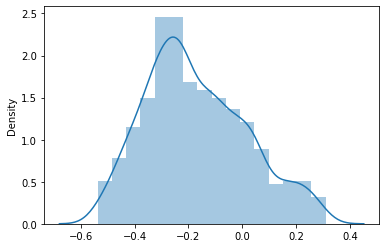

In [86]:
m = Moran(x1, w1)
p = [Moran(np.random.permutation(m.z), m.w).moran() for i in range(999)]
print(m.moran())
sns.distplot(p);

In [71]:
class Moran():
    def __init__(self, x, w):
        self.x = x
        self.n = x.size
        self.EI = -(1/(self.n-1))
        self.z = self.x - self.x.mean()
        self.z2s = (self.z ** 2).sum()
        
        self.w = np.array([w[i]/w[i].sum() for i in range(self.n)])
        self.s0 = self.w.sum().sum()
        self.s1 = np.array(
            [(self.w[i,j] + self.w[j,i]) ** 2 for i in range(self.n) for j in range(self.n)]
        ).sum() * 0.5
        self.s2 = np.array([(self.w[i,:].sum() + self.w[:,i].sum()) ** 2 for i in range(self.n)]).sum()
    
    def moran(self):
        I_numerador = np.array(
            [self.w[i,j] * self.z[i] * self.z[j] for i in range(self.n) for j in range(self.n)]
        ).sum() * self.n
        I_denominador = self.s0 * self.z2s
        return I_numerador / I_denominador
    
    def EI2():
        self.z4 = self.z ** 4
        self.z2 = self.z ** 2
        self.k = (self.z4.sum() / self.n) / ((self.z2.sum() / self.n) ** 2)

        self.A = self.n * ((self.n ** 2 - 3 * self.n + 3) * self.s1 - self.n * self.s2 + 3 * self.s0 ** 2)
        self.B = self.k * ((self.n ** 2 - self.n) * self.s1 - 2 * self.n * self.s2 + 6 * self.s0 ** 2)
        self.C = (self.n - 1) * (self.n - 2) * (self.n - 3) * self.s0 ** 2

        self.EI2 = (self.A - self.B) / self.C 

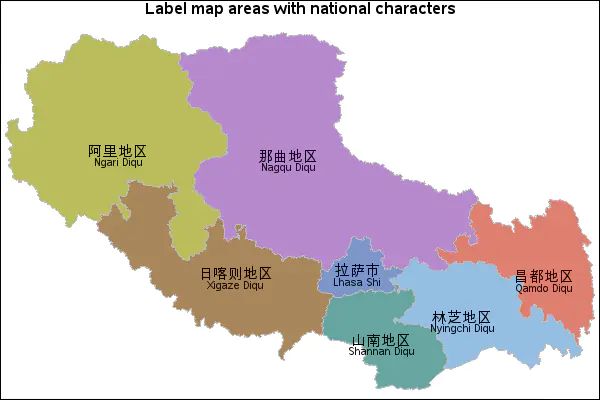


-0.09859381486093816


/media/Shared/Projeto Pesquisa/spatio-temporal-analysis-calazar/venvironment/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

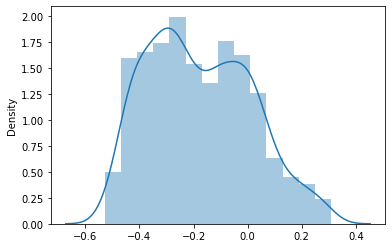

In [72]:
x1 = np.array([1,12,25,17,10,4,2])
w1 = np.array([
    [0,1,1,0,0,0,0],
    [1,0,1,1,0,1,1],
    [1,1,0,1,1,0,0],
    [0,1,1,0,1,1,0],
    [0,0,1,1,0,1,0],
    [0,1,0,1,1,0,1],
    [0,1,0,0,0,1,0]
])
m = Moran(x1, w1)
print(m.moran())
p = np.array([Moran(np.random.permutation(m.z), m.w).moran() for i in range(999)])
sns.distplot(p)